# Random forest classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution.

## 1. Data acquisition

In [18]:
import pandas as pd

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")

### 1.2. Train-test split

In [19]:
from sklearn.model_selection import train_test_split

# Separate features from labels
labels=data_df['Outcome']
features=data_df.drop('Outcome', axis=1)

# Split the data into training and testing features and labels
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=315
)

## 2. EDA

### 2.1. Features

In [20]:
# Inspect the training features' data types
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 765 to 611
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 43.2 KB


All of the features are already numeric - we don't need to do anything for the model to run. Let's check the labels too.

### 2.2. Labels

In [21]:
training_labels.info()

<class 'pandas.core.series.Series'>
Index: 614 entries, 765 to 611
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
614 non-null    int64
dtypes: int64(1)
memory usage: 9.6 KB


Also, already numeric - we can move right to training the model and setting a baseline performance result.

## 3. Training

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate and train decision tree classifier
model=RandomForestClassifier(random_state=315)
fit_result=model.fit(training_features, training_labels)

## 4. Evaluation

In [23]:
from sklearn.metrics import accuracy_score

# Make predictions from test set features
predicted_labels=model.predict(testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 77.9% accurate on the test data


Ok, done! Absolutely minimal random forest classifier using ~10 statements. Out of the box, the random forest performs slightly better than a single decision tree classifier. But, there are still many things we could do to try and improve it.

In [24]:
import numpy as np
from sklearn.impute import SimpleImputer

training_features[['BloodPressure', 'Glucose']] = training_features[['BloodPressure', 'Glucose']].replace(0, np.nan)

imputer = SimpleImputer(strategy='median')
training_features[['BloodPressure', 'Glucose']] = imputer.fit_transform(training_features[['BloodPressure', 'Glucose']])

print(training_features[['BloodPressure', 'Glucose']].isnull().sum())

BloodPressure    0
Glucose          0
dtype: int64


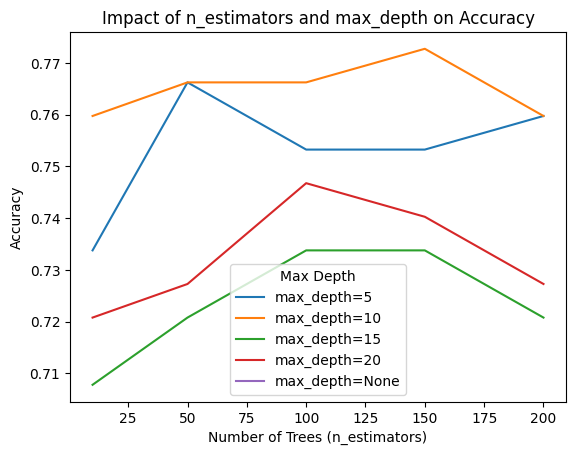

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_estimators_range = [10, 50, 100, 150, 200]
max_depth_range = [5, 10, 15, 20, None]

results = []

for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=315)
        model.fit(training_features, training_labels)
       
        predicted_labels = model.predict(testing_features)
        
        accuracy = accuracy_score(testing_labels, predicted_labels)
        
        results.append({'n_estimators': n_estimators, 'max_depth': max_depth, 'accuracy': accuracy})


import pandas as pd
results_df = pd.DataFrame(results)

fig, ax = plt.subplots()
for max_depth in max_depth_range:
    subset = results_df[results_df['max_depth'] == max_depth]
    ax.plot(subset['n_estimators'], subset['accuracy'], label=f'max_depth={max_depth}')

ax.set_xlabel('Number of Trees (n_estimators)')
ax.set_ylabel('Accuracy')
ax.set_title('Impact of n_estimators and max_depth on Accuracy')
ax.legend(title='Max Depth')
plt.show()


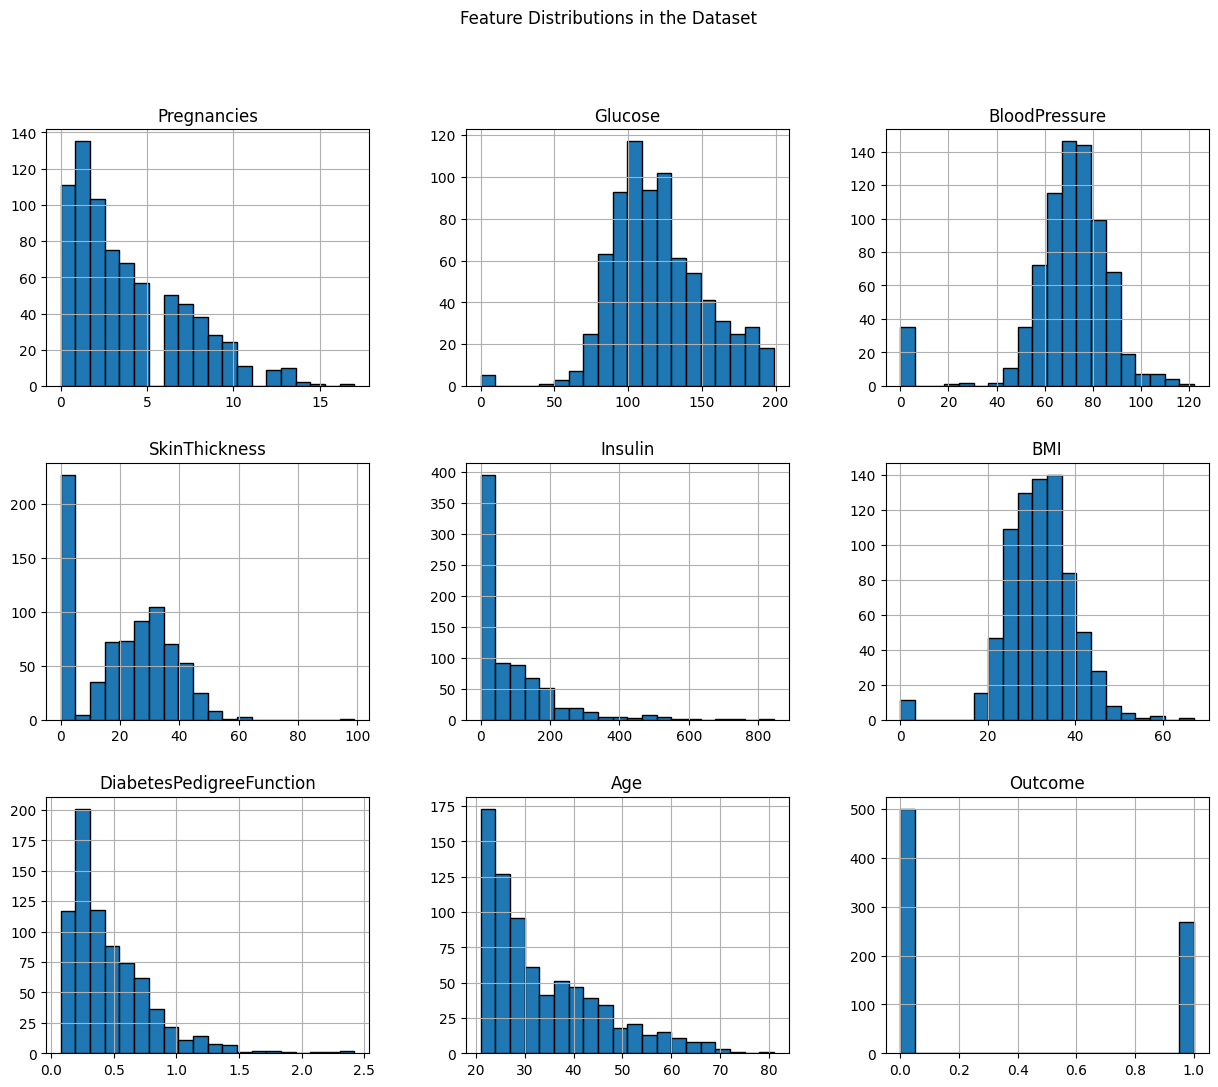

In [26]:
import matplotlib.pyplot as plt

# Plot histograms for each feature in the dataset
data_df.hist(bins=20, figsize=(15, 12), edgecolor='black')
plt.suptitle("Feature Distributions in the Dataset")
plt.show()


In [27]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest model
rf_model = RandomForestClassifier(random_state=315)

# Train the model on the training data
rf_model.fit(training_features, training_labels)

# Predict on the test data
rf_predictions = rf_model.predict(testing_features)

# Calculate accuracy
rf_accuracy = accuracy_score(testing_labels, rf_predictions)
print(f"Random Forest Model Accuracy: {rf_accuracy * 100:.2f}%")


Random Forest Model Accuracy: 74.68%


In [28]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Perform grid search on training data
grid_search_rf.fit(training_features, training_labels)

# Get the best parameters and model
best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

print(f"Best Hyperparameters for Random Forest: {best_params_rf}")


Best Hyperparameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


/home/vscode/.local/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [29]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation = StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

    # Run cross-validation, collecting the scores
    scores = cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='accuracy'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross-validation accuracy: {(scores.mean() * 100):.2f} +/- {(scores.std() * 100):.2f}%')

    # Return the scores
    return scores


In [30]:
# Run cross-validation on the optimized Random Forest model
cv_scores_rf = cross_val(best_rf_model, training_features, training_labels)

# Calculate and display the mean and standard deviation of the cross-validation scores
print(f"Cross-validation accuracy for the optimized Random Forest model: {np.mean(cv_scores_rf) * 100:.2f}% +/- {np.std(cv_scores_rf) * 100:.2f}%")


Cross-validation accuracy: 76.38 +/- 5.90%
Cross-validation accuracy for the optimized Random Forest model: 76.38% +/- 5.90%


In [31]:
import joblib
import os

# Define the folder path where the model should be saved
folder_path = "models"
os.makedirs(folder_path, exist_ok=True)

# Save the trained model
model_filename = os.path.join(folder_path, "random_forest_model.joblib")
joblib.dump(model, model_filename)

print(f"Model saved to {model_filename}")


Model saved to models/random_forest_model.joblib


In [32]:
loaded_model = joblib.load(model_filename)


In [33]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Make predictions on the test set
predicted_labels = loaded_model.predict(testing_features)

# Calculate accuracy
accuracy = accuracy_score(testing_labels, predicted_labels) * 100
print(f'The loaded model is {accuracy:.1f}% accurate on the test data')


The loaded model is 72.7% accurate on the test data


In [34]:
from sklearn.model_selection import GridSearchCV

# Define a grid of parameters to search
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 15, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with the random forest model
grid_search = GridSearchCV(RandomForestClassifier(random_state=315), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(training_features, training_labels)

# Use the best estimator
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}


In [35]:
# Train a new Random Forest model with the best parameters
best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    random_state=315
)
best_model.fit(training_features, training_labels)

# Evaluate accuracy on the test set
predicted_labels = best_model.predict(testing_features)
accuracy = accuracy_score(testing_labels, predicted_labels) * 100
print(f'The improved model is {accuracy:.1f}% accurate on the test data')

# Save the improved model
import joblib
model_filename = "models/improved_random_forest_model.joblib"
joblib.dump(best_model, model_filename)
print(f"Improved model saved to {model_filename}")


The improved model is 74.7% accurate on the test data
Improved model saved to models/improved_random_forest_model.joblib


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initializing a list to store results
results = []

# Define parameter settings to test
param_grid = [
    {'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': True},
    {'n_estimators': 250, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': False},
    {'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': True, 'oob_score': True},
    {'n_estimators': 200, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': True}
]

# Train and evaluate models with each set of parameters
for params in param_grid:
    model = RandomForestClassifier(random_state=315, **params)
    model.fit(training_features, training_labels)
    
    # OOB score if bootstrap=True and oob_score=True
    if 'oob_score' in params and params['oob_score']:
        print(f"OOB Score with params {params}: {model.oob_score_ * 100:.2f}%")

    # Predict on the test set
    predicted_labels = model.predict(testing_features)
    accuracy = accuracy_score(testing_labels, predicted_labels) * 100
    results.append({'params': params, 'test_accuracy': accuracy})
    print(f"Test Accuracy with params {params}: {accuracy:.2f}%")

# Analyze results to see which parameter combination yielded the highest accuracy
best_result = max(results, key=lambda x: x['test_accuracy'])
print("\nBest Parameters and Accuracy:")
print(best_result)


Test Accuracy with params {'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': True}: 74.68%
Test Accuracy with params {'n_estimators': 250, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': False}: 74.03%
OOB Score with params {'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': True, 'oob_score': True}: 76.22%
Test Accuracy with params {'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': True, 'oob_score': True}: 74.68%
Test Accuracy with params {'n_estimators': 200, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': True}: 75.32%

Best Parameters and Accuracy:
{'params': {'n_estimators': 200, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'bootstrap': True}, 'test_accuracy': 75.32467532467533}


In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test data using the optimized Random Forest model
final_rf_predictions = best_rf_model.predict(testing_features)

# Calculate accuracy
final_rf_accuracy = accuracy_score(testing_labels, final_rf_predictions)

# Generate confusion matrix
conf_matrix_rf = confusion_matrix(testing_labels, final_rf_predictions)

# Classification report for precision, recall, and F1-score
class_report_rf = classification_report(testing_labels, final_rf_predictions)

# Display the results
print(f"Final Model Accuracy for Random Forest: {final_rf_accuracy * 100:.2f}%")
print("\nConfusion Matrix for Random Forest:")
print(conf_matrix_rf)
print("\nClassification Report for Random Forest:")
print(class_report_rf)



Final Model Accuracy for Random Forest: 73.38%

Confusion Matrix for Random Forest:
[[83 16]
 [25 30]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80        99
           1       0.65      0.55      0.59        55

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.73      0.73       154



In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define a wider parameter grid for Randomized Search
param_distributions = {
    'n_estimators': np.arange(50, 300, 50),       # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],      # Maximum depth of the trees
    'min_samples_split': [2, 5, 10, 15, 20],      # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6, 8],          # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],     # Number of features to consider for each split
    'bootstrap': [True, False]                    # Whether bootstrap samples are used when building trees
}

# Initialize a Random Forest model
rf_model = RandomForestClassifier(random_state=315)

# Set up Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=50,               # Number of random configurations to try
    scoring='accuracy',
    cv=5,                    # 5-fold cross-validation
    n_jobs=-1,               # Use all available cores
    random_state=315,
    verbose=1
)

# Perform Randomized Search on the training data
random_search.fit(training_features, training_labels)

# Best parameters and model
best_params_rf = random_search.best_params_
best_rf_model = random_search.best_estimator_

print(f"Best Hyperparameters from Randomized Search: {best_params_rf}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters from Randomized Search: {'n_estimators': np.int64(50), 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}


/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
95 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/vscode/.loca

In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test data using the optimized Random Forest model
final_rf_predictions = best_rf_model.predict(testing_features)

# Calculate accuracy
final_rf_accuracy = accuracy_score(testing_labels, final_rf_predictions)

# Generate confusion matrix
conf_matrix_rf = confusion_matrix(testing_labels, final_rf_predictions)

# Classification report for precision, recall, and F1-score
class_report_rf = classification_report(testing_labels, final_rf_predictions)

# Display the results
print(f"Final Model Accuracy for Random Forest: {final_rf_accuracy * 100:.2f}%")
print("\nConfusion Matrix for Random Forest:")
print(conf_matrix_rf)
print("\nClassification Report for Random Forest:")
print(class_report_rf)

Final Model Accuracy for Random Forest: 75.97%

Confusion Matrix for Random Forest:
[[84 15]
 [22 33]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        99
           1       0.69      0.60      0.64        55

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154



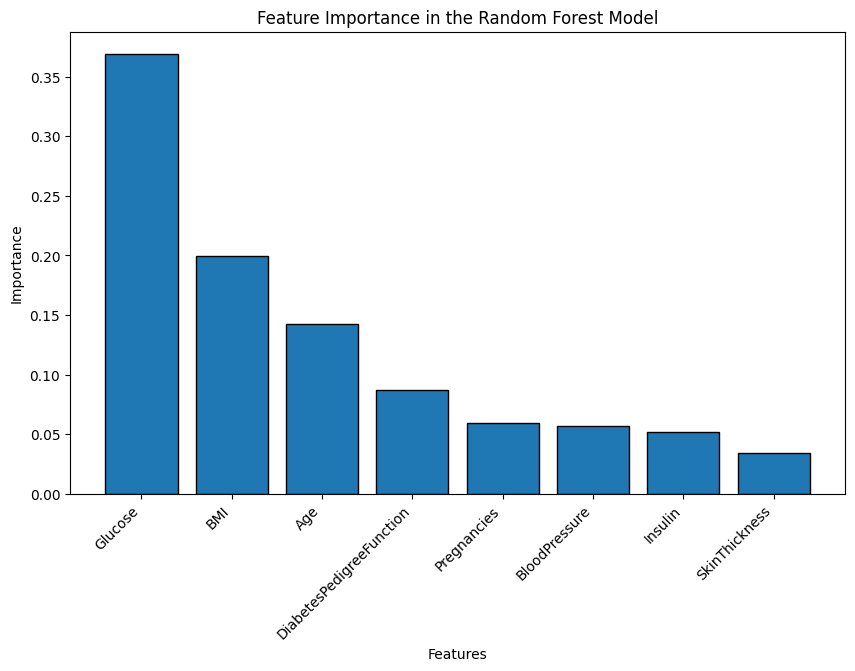

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance from the best random forest model
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for easy plotting
importances_df = pd.DataFrame({
    'Feature': training_features.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importances_df['Feature'], importances_df['Importance'], edgecolor='black')
plt.title("Feature Importance in the Random Forest Model")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.show()


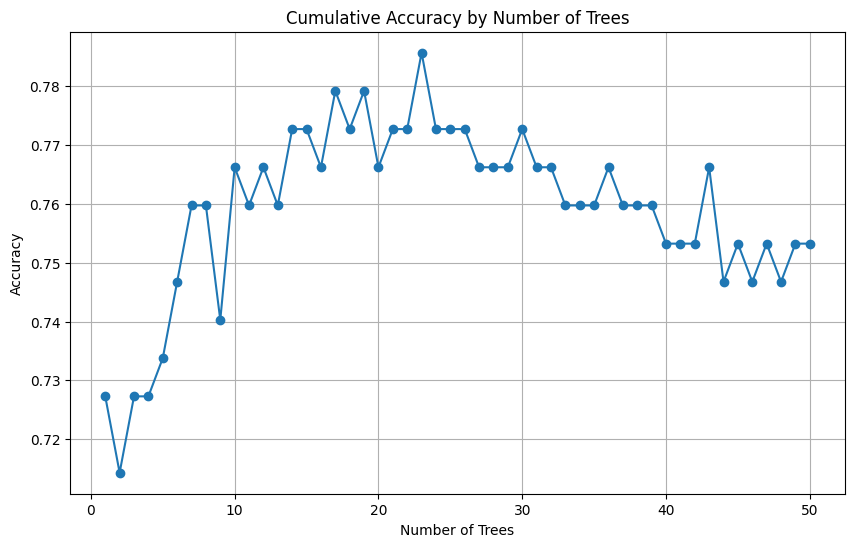

In [44]:
cumulative_accuracies = []

# Evaluate cumulative accuracy as more trees are added
for n_trees in range(1, len(best_rf_model.estimators_) + 1):
    partial_model = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=best_rf_model.max_depth,
        max_features=best_rf_model.max_features,
        random_state=315
    )
    partial_model.fit(training_features, training_labels)
    predictions = partial_model.predict(testing_features)
    cumulative_accuracies.append(accuracy_score(testing_labels, predictions))

# Plot cumulative accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_accuracies) + 1), cumulative_accuracies, marker='o')
plt.title("Cumulative Accuracy by Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
